In [18]:
!pip install tensorflow opencv-python scikit-learn xgboost matplotlib seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.6 MB 6.3 MB/s eta 0:00:02
   --------- ------------------------------ 2.9/11.6 MB 8.0 MB/s eta 0:00:02
   ------------- -------------------------- 3.9/11.6 MB 7.1 MB/s eta 0:00:02
   ------------------ --------------------- 5.2/11.6 MB 6.9 MB/s eta 0:00:01
   ----------------------- ---------------- 6.8/11.6 MB 7.0 MB/s eta 0:00:01
   ------------------------------ --------- 8.9/11.6 MB 7.6 MB/s eta 0:00:01
   ------------------------------------ --- 10.7/11.6 MB 7.8 MB/s eta 0:00:01
   ---------------------------------------  11.5/11.6 MB 7.8 MB/s eta 0:00:01
   ---------------------------------------- 11.6/11.6 MB 6.7

In [3]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [4]:
def load_images_and_labels(dataset_path, img_size=(128, 128)):
    images = []
    labels = []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            
            # Check if the image is loaded successfully
            if img is None:
                print(f"Warning: Failed to load image at path: {img_path}")
                continue  # Skip this image and move to the next one
            
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(folder)
    
    images = np.array(images) / 255.0  # Normalize images
    return images, labels


In [5]:
%%time
dataset_path = r'dataset'
img_size = (128, 128)
images, labels = load_images_and_labels(dataset_path, img_size)


CPU times: total: 4.91 s
Wall time: 1min 8s


In [6]:
%%time
# Step 2: Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)


CPU times: total: 0 ns
Wall time: 3.58 ms


In [7]:
%%time
# Step 3: Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)


CPU times: total: 344 ms
Wall time: 417 ms


In [8]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([up1, conv2])
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([up2, conv1])
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Global Average Pooling and Dense Layer for Classification
    gap = GlobalAveragePooling2D()(conv5)
    outputs = Dense(len(np.unique(labels_encoded)), activation='softmax')(gap)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

unet = unet_model(input_size=(img_size[0], img_size[1], 3))


In [9]:
%%time
unet.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))


Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 808s 3s/step - accuracy: 0.3277 - loss: 1.9763 - val_accuracy: 0.3516 - val_loss: 1.7395
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 788s 2s/step - accuracy: 0.3775 - loss: 1.7266 - val_accuracy: 0.3501 - val_loss: 1.6516
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 789s 2s/step - accuracy: 0.4044 - loss: 1.6050 - val_accuracy: 0.4796 - val_loss: 1.4643
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 784s 2s/step - accuracy: 0.4897 - loss: 1.3897 - val_accuracy: 0.4262 - val_loss: 1.7738
Epoch 5/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 784s 2s/step - accuracy: 0.5556 - loss: 1.1904 - val_accuracy: 0.5793 - val_loss: 1.1786
Epoch 6/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 790s 2s/step - accuracy: 0.5988 - loss: 1.0887 - val_accuracy: 0.5667 - val_loss: 1.2260
Epoch 7/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 786s 2s/step - accuracy: 0.6076 - loss: 1.0424 - val_accuracy: 0.6264 - val_loss: 1.0737
Epoch 8/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 787s 2s/step - accuracy: 0.6269 - loss: 1.0176 - val_accu

In [10]:
# model_save_path = 'unet_model.h5'
# unet.save(model_save_path)

# print(f"Model saved to {model_save_path}")

In [13]:
# Step 1: Accuracy on Validation Set
val_accuracy = unet.evaluate(X_val, y_val, verbose=0)[1]  # [1] is for accuracy
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Step 2: Classification Report and Confusion Matrix
y_val_pred = unet.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

print("Classification Report:")
print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=label_encoder.classes_))



Validation Accuracy: 63.42%
40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step
Classification Report:
                     precision    recall  f1-score   support

                CaS       0.00      0.00      0.00        16
           Calculus       0.64      0.54      0.59       271
                CoS       0.17      0.62      0.27         8
        Data caries       0.00      0.00      0.00        40
         Gingivitis       0.73      0.76      0.75       448
                Gum       0.00      0.00      0.00         9
                 MC       0.00      0.00      0.00         8
        Mouth Ulcer       0.25      0.25      0.25        52
                 OC       0.00      0.00      0.00        11
                OLP       0.00      0.00      0.00        20
                 OT       0.00      0.00      0.00        12
Tooth Discoloration       0.14      0.41      0.21        32
  blackhair toungue       0.60      0.87      0.71        68
       cancer sores       0.17      0.45      0.25     

c:\Users\haric\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\haric\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\haric\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


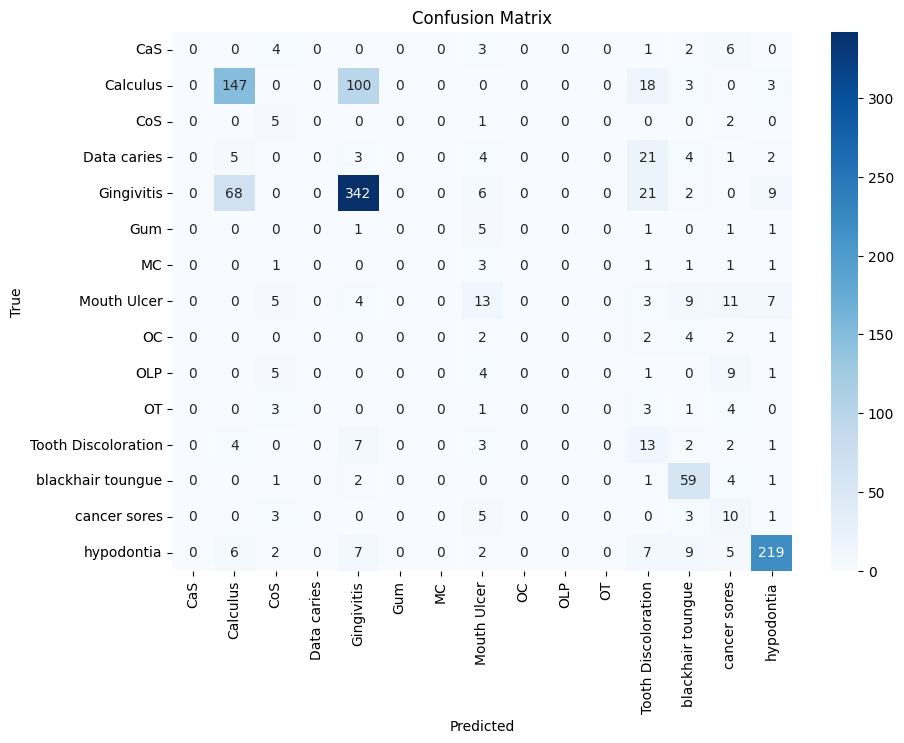

40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step
ROC-AUC Score: 0.9249


NameError: name 'history' is not defined

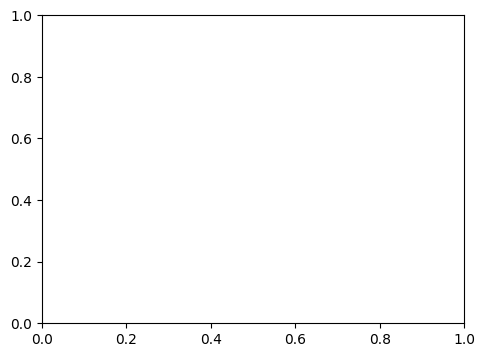

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
# Confusion Matrix
cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Step 3: ROC-AUC Score for Multi-Class Classification
y_val_prob = unet.predict(X_val)  # Predict probabilities
roc_auc = roc_auc_score(y_val, y_val_prob, multi_class="ovr")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Step 4: Plotting Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# second Try

In [25]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import time

# Function to load images and labels from a directory structure
def load_images_and_labels(dataset_path, img_size=(128, 128)):
    images = []
    labels = []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    labels.append(folder)
                else:
                    print(f"Warning: Failed to load image at path: {img_path}")
    images = np.array(images) / 255.0  # Normalize images
    return images, np.array(labels)

# Create a data generator for data augmentation
def create_datagen():
    datagen = ImageDataGenerator(
        rotation_range=20,        # Random rotation between 0 and 20 degrees
        width_shift_range=0.2,    # Random horizontal shift
        height_shift_range=0.2,   # Random vertical shift
        shear_range=0.2,          # Shear transformation
        zoom_range=0.2,           # Zoom in/out
        horizontal_flip=True,     # Randomly flip images horizontally
        fill_mode='nearest'       # Fill any empty pixels with nearest mode
    )
    return datagen

# U-Net model definition
def unet_model(input_size=(128, 128, 3), num_classes=15):
    inputs = Input(input_size)
    
    # Encoder with L2 regularization
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck with Dropout
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = Dropout(0.5)(conv4)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv4)
    up1 = concatenate([up1, conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up2 = UpSampling2D(size=(2, 2))(conv5)
    up2 = concatenate([up2, conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up2)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up3 = UpSampling2D(size=(2, 2))(conv6)
    up3 = concatenate([up3, conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    conv7 = Dropout(0.5)(conv7)

    # Global Average Pooling and Dense Layer for Classification
    gap = GlobalAveragePooling2D()(conv7)
    outputs = Dense(num_classes, activation='softmax')(gap)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Main function to run the full pipeline
def main():
    # Set the dataset path and image size
    dataset_path = r'dataset'  # Use the 'dataset' folder in the current directory
    img_size = (128, 128)
    
    # Measure time to load images
    print("Loading images...")
    start_time = time.time()  # Start timing
    images, labels = load_images_and_labels(dataset_path, img_size)
    end_time = time.time()  # End timing
    print(f"Loaded {len(images)} images from {dataset_path} in {end_time - start_time:.2f} seconds")

    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_categorical = np.eye(len(np.unique(labels_encoded)))[labels_encoded]

    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

    # Create data generator
    datagen = create_datagen()
    datagen.fit(X_train)

    # Build the model
    num_classes = len(np.unique(labels_encoded))
    unet = unet_model(input_size=(img_size[0], img_size[1], 3), num_classes=num_classes)

    # Learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

    # Train the model
    history = unet.fit(datagen.flow(X_train, y_train, batch_size=16),
                       epochs=30,  # Increase the number of epochs
                       validation_data=(X_val, y_val),
                       callbacks=[lr_scheduler])

    # Save the model
    unet.save('unet_model2.h5')

    # Plot training history
    plot_training_history(history)

    # Evaluate the model on the validation set
    val_accuracy = unet.evaluate(X_val, y_val, verbose=0)[1]
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Predict on the validation set
    y_val_pred = unet.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

if __name__ == "__main__":
    main()


Loading images...
Loaded 6367 images from dataset in 47.61 seconds
Epoch 1/30


c:\Users\haric\anaconda3\envs\project\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


319/319 ━━━━━━━━━━━━━━━━━━━━ 1130s 4s/step - accuracy: 0.3325 - loss: 2.5097 - val_accuracy: 0.3611 - val_loss: 1.7548 - learning_rate: 0.0010
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1135s 4s/step - accuracy: 0.3624 - loss: 1.7560 - val_accuracy: 0.3516 - val_loss: 1.7183 - learning_rate: 0.0010
Epoch 3/30
281/319 ━━━━━━━━━━━━━━━━━━━━ 23:16 37s/step - accuracy: 0.3770 - loss: 1.7284

KeyboardInterrupt: 

Loading images...
Loaded 6367 images from dataset in 162.81 seconds
Displaying sample images and their augmented versions...


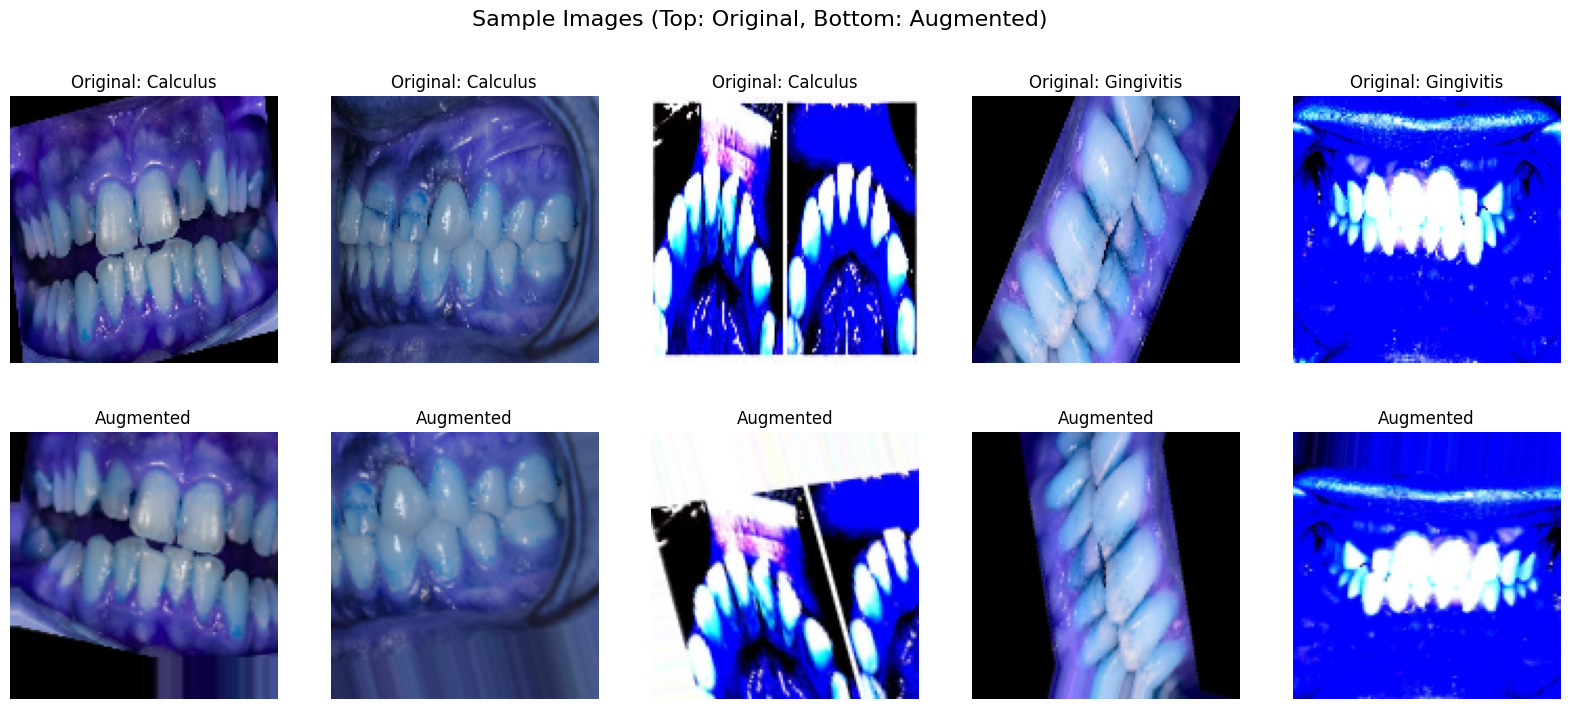

Epoch 1/10


c:\Users\haric\anaconda3\envs\project\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


319/319 ━━━━━━━━━━━━━━━━━━━━ 1331s 4s/step - accuracy: 0.3383 - loss: 2.1476 - val_accuracy: 0.3516 - val_loss: 1.7756 - learning_rate: 0.0010
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1238s 4s/step - accuracy: 0.3734 - loss: 1.7943 - val_accuracy: 0.3477 - val_loss: 1.7656 - learning_rate: 0.0010
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1471s 5s/step - accuracy: 0.3795 - loss: 1.7294 - val_accuracy: 0.3909 - val_loss: 1.6871 - learning_rate: 0.0010
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1237s 4s/step - accuracy: 0.3754 - loss: 1.6948 - val_accuracy: 0.4097 - val_loss: 1.6911 - learning_rate: 0.0010
Epoch 5/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1317s 4s/step - accuracy: 0.4184 - loss: 1.5669 - val_accuracy: 0.4717 - val_loss: 1.4541 - learning_rate: 0.0010
Epoch 6/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1316s 4s/step - accuracy: 0.5232 - loss: 1.3644 - val_accuracy: 0.5251 - val_loss: 1.3450 - learning_rate: 0.0010
Epoch 7/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1381s 4s/step - accuracy: 0.5444 - loss: 1.2934

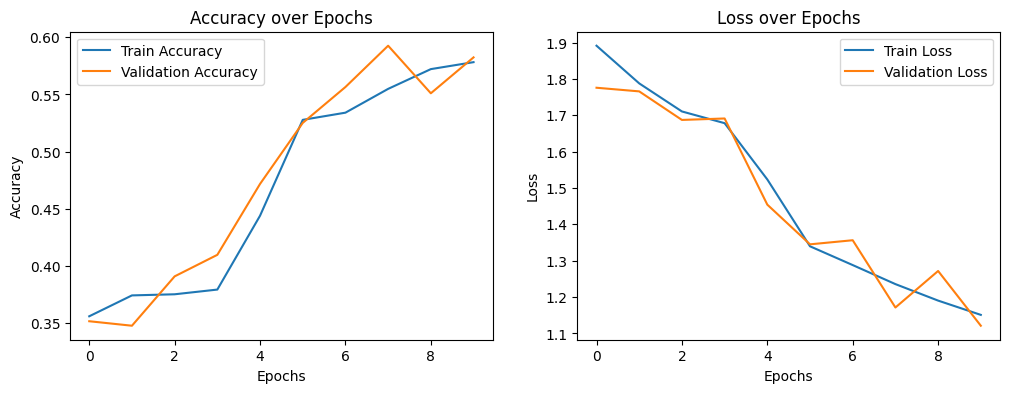

Validation Accuracy: 58.24%
40/40 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step
Classification Report:
                     precision    recall  f1-score   support

                CaS       0.00      0.00      0.00        16
           Calculus       0.60      0.30      0.40       271
                CoS       0.00      0.00      0.00         8
        Data caries       1.00      0.03      0.05        40
         Gingivitis       0.56      0.87      0.68       448
                Gum       0.00      0.00      0.00         9
                 MC       0.00      0.00      0.00         8
        Mouth Ulcer       0.25      0.48      0.32        52
                 OC       0.00      0.00      0.00        11
                OLP       0.00      0.00      0.00        20
                 OT       0.00      0.00      0.00        12
Tooth Discoloration       0.22      0.06      0.10        32
  blackhair toungue       0.61      0.69      0.65        68
       cancer sores       0.00      0.00      0.00     

c:\Users\haric\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\haric\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\haric\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


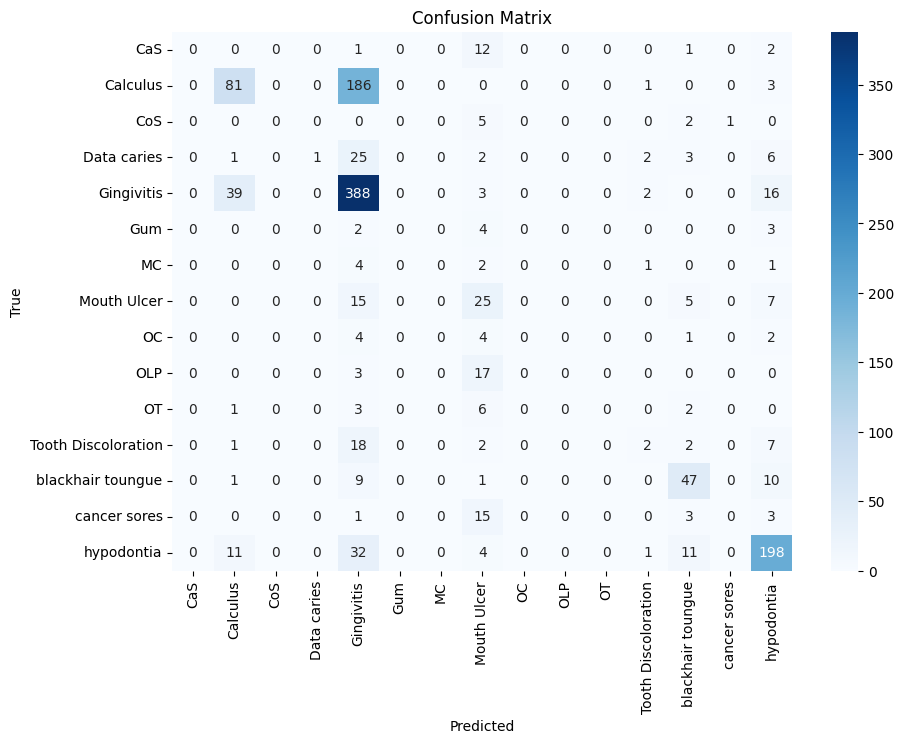

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import time

# Function to load images and labels from a directory structure
def load_images_and_labels(dataset_path, img_size=(128, 128)):
    images = []
    labels = []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    labels.append(folder)
                else:
                    print(f"Warning: Failed to load image at path: {img_path}")
    images = np.array(images) / 255.0  # Normalize images
    return images, np.array(labels)

# Function to display sample images and their augmented versions
def display_sample_images(images, labels, datagen, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(20, 8))
    selected_indices = np.random.choice(len(images), num_images, replace=False)

    for i, ax in enumerate(axes[0]):
        ax.imshow(images[selected_indices[i]])
        ax.set_title(f"Original: {labels[selected_indices[i]]}")
        ax.axis('off')

    for i, ax in enumerate(axes[1]):
        img = images[selected_indices[i]].reshape((1,) + images[selected_indices[i]].shape)  # Reshape for flow
        augmented_img = next(datagen.flow(img))[0]
        ax.imshow(augmented_img)
        ax.set_title("Augmented")
        ax.axis('off')

    plt.suptitle('Sample Images (Top: Original, Bottom: Augmented)', fontsize=16)
    plt.show()

# Create a data generator for data augmentation
def create_datagen():
    datagen = ImageDataGenerator(
        rotation_range=20,        # Random rotation between 0 and 20 degrees
        width_shift_range=0.2,    # Random horizontal shift
        height_shift_range=0.2,   # Random vertical shift
        shear_range=0.2,          # Shear transformation
        zoom_range=0.2,           # Zoom in/out
        horizontal_flip=True,     # Randomly flip images horizontally
        fill_mode='nearest'       # Fill any empty pixels with nearest mode
    )
    return datagen

# U-Net model definition
def unet_model(input_size=(128, 128, 3), num_classes=15):
    inputs = Input(input_size)
    
    # Encoder with L2 regularization
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck with Dropout
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = Dropout(0.5)(conv4)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv4)
    up1 = concatenate([up1, conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up2 = UpSampling2D(size=(2, 2))(conv5)
    up2 = concatenate([up2, conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up2)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up3 = UpSampling2D(size=(2, 2))(conv6)
    up3 = concatenate([up3, conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    conv7 = Dropout(0.5)(conv7)

    # Global Average Pooling and Dense Layer for Classification
    gap = GlobalAveragePooling2D()(conv7)
    outputs = Dense(num_classes, activation='softmax')(gap)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Main function to run the full pipeline
def main():
    # Set the dataset path and image size
    dataset_path = r'dataset'  # Use the 'dataset' folder in the current directory
    img_size = (128, 128)
    
    # Measure time to load images
    print("Loading images...")
    start_time = time.time()  # Start timing
    images, labels = load_images_and_labels(dataset_path, img_size)
    end_time = time.time()  # End timing
    print(f"Loaded {len(images)} images from {dataset_path} in {end_time - start_time:.2f} seconds")

    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_categorical = np.eye(len(np.unique(labels_encoded)))[labels_encoded]

    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

    # Create data generator
    datagen = create_datagen()
    datagen.fit(X_train)

    # Display some sample images and their augmented versions
    print("Displaying sample images and their augmented versions...")
    display_sample_images(X_train, label_encoder.inverse_transform(np.argmax(y_train, axis=1)), datagen, num_images=5)

    # Build the model
    num_classes = len(np.unique(labels_encoded))
    unet = unet_model(input_size=(img_size[0], img_size[1], 3), num_classes=num_classes)

    # Learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

    # Train the model
    history = unet.fit(datagen.flow(X_train, y_train, batch_size=16),
                       epochs=10,  # Increase the number of epochs
                       validation_data=(X_val, y_val),
                       callbacks=[lr_scheduler])

    # Save the model
    unet.save('unet_model2.h5')

    # Plot training history
    plot_training_history(history)

    # Evaluate the model on the validation set
    val_accuracy = unet.evaluate(X_val, y_val, verbose=0)[1]
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Predict on the validation set
    y_val_pred = unet.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

if __name__ == "__main__":
    main()


# Try 3

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import time

# Function to load images and labels from a directory structure
def load_images_and_labels(dataset_path, img_size=(128, 128)):
    images = []
    labels = []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    labels.append(folder)
                else:
                    print(f"Warning: Failed to load image at path: {img_path}")
    images = np.array(images) / 255.0  # Normalize images
    return images, np.array(labels)

# Residual block
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    return x

# Improved U-Net model definition with residual connections and batch normalization
def unet_model(input_size=(128, 128, 3), num_classes=15):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = residual_block(conv1, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = residual_block(conv2, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = residual_block(conv3, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = residual_block(conv4, 512)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv4)
    up1 = concatenate([up1, conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up1)
    conv5 = residual_block(conv5, 256)
    conv5 = Dropout(0.5)(conv5)

    up2 = UpSampling2D(size=(2, 2))(conv5)
    up2 = concatenate([up2, conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up2)
    conv6 = residual_block(conv6, 128)
    conv6 = Dropout(0.5)(conv6)

    up3 = UpSampling2D(size=(2, 2))(conv6)
    up3 = concatenate([up3, conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up3)
    conv7 = residual_block(conv7, 64)
    conv7 = Dropout(0.5)(conv7)

    # Global Average Pooling and Dense Layer for Classification
    gap = GlobalAveragePooling2D()(conv7)
    outputs = Dense(num_classes, activation='softmax')(gap)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Main function to run the full pipeline
def main():
    # Set the dataset path and image size
    dataset_path = r'dataset'  # Use the 'dataset' folder in the current directory
    img_size = (128, 128)
    
    # Measure time to load images
    print("Loading images...")
    start_time = time.time()  # Start timing
    images, labels = load_images_and_labels(dataset_path, img_size)
    end_time = time.time()  # End timing
    print(f"Loaded {len(images)} images from {dataset_path} in {end_time - start_time:.2f} seconds")

    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_categorical = np.eye(len(np.unique(labels_encoded)))[labels_encoded]

    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

    # Build the model
    num_classes = len(np.unique(labels_encoded))
    unet = unet_model(input_size=(img_size[0], img_size[1], 3), num_classes=num_classes)

    # Learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

    # Train the model
    history = unet.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_val, y_val), callbacks=[lr_scheduler])

    # Save the model
    unet.save('unet_model_improved.h5')

    # Plot training history
    plot_training_history(history)

    # Evaluate the model on the validation set
    val_accuracy = unet.evaluate(X_val, y_val, verbose=0)[1]
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Predict on the validation set
    y_val_pred = unet.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

if __name__ == "__main__":
    main()



Loading images...
Loaded 6367 images from dataset in 29.90 seconds
Epoch 1/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2297s 7s/step - accuracy: 0.4687 - loss: 1.6198 - val_accuracy: 0.0424 - val_loss: 4.3683 - learning_rate: 1.0000e-04
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2187s 7s/step - accuracy: 0.6002 - loss: 1.0821 - val_accuracy: 0.3673 - val_loss: 1.9268 - learning_rate: 1.0000e-04
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2152s 7s/step - accuracy: 0.6419 - loss: 0.9699 - val_accuracy: 0.5973 - val_loss: 1.1507 - learning_rate: 1.0000e-04
Epoch 4/30
 60/319 ━━━━━━━━━━━━━━━━━━━━ 26:50 6s/step - accuracy: 0.6772 - loss: 0.8534

KeyboardInterrupt: 